In [2]:
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import rnn as rnn_utils
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
# from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CyclicLR, LambdaLR, ReduceLROnPlateau, MultiStepLR

from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, RandomResizedCrop, Normalize, Pad
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, inception_v3, alexnet
from torchvision.models.alexnet import AlexNet_Weights
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models.inception import Inception_V3_Weights
# from torchvision.models.vgg import VGG16_Weights

from torch_lr_finder import LRFinder

from tqdm.autonotebook import tqdm
# from tqdm.auto import tqdm
from datetime import datetime as dt
import os
import random
from copy import deepcopy
from pathlib import Path
import shutil

from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [13]:
# alexnet_model = alexnet(weights=AlexNet_Weights.DEFAULT)
# alexnet_model

# resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)
# resnet18_model

# inception_v3_model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
# inception_v3_model

In [3]:
# Setting the data for testing

np.random.seed(42)
X = np.random.randn(1000, 5)

a = np.array([0.2, 0.1, 0.4, -0.7, 0.03]).reshape(-1, 1)
b = -0.9
y = b + X @ a

print(X.shape, y.shape)

(1000, 5) (1000, 1)


# Data configuration

In [4]:
%%writefile data_config/data_prep.py

np.random.seed(42)
X = np.random.randn(1000, 5)

a = np.array([0.2, 0.1, 0.4, -0.7, 0.03]).reshape(-1, 1)
b = -0.9
y = b + X @ a

X_tensor = torch.as_tensor(X).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(X.shape[0] * 0.8)
valid_size = X.shape[0] - train_size

train_data, valid_data = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

valid_loader = DataLoader(
    dataset=valid_data,
    batch_size=32
)

Overwriting data_config/data_prep.py


# Model configuration

In [5]:
%load_ext tensorboard
%tensorboard --logdir summary

Reusing TensorBoard on port 6006 (pid 17044), started 1 day, 22:47:47 ago. (Use '!kill 17044' to kill it.)

In [6]:
%%writefile model_config/model_setting.py

def create_train_step_fn(model, loss_fn, optimizer):
    def output_train_step_loss(X, y):
        model.train()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return output_train_step_loss

def create_valid_step_fn(model, loss_fn):
    def output_valid_step_loss(X, y):
        model.eval()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        return loss.item()
    return output_valid_step_loss

def get_mini_batch_loss(device, data_loader, step_fn):
    mini_batch_losses = []
    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        batch_loss = step_fn(X_batch, y_batch)
        mini_batch_losses.append(batch_loss)
    
    return np.mean(mini_batch_losses)

lr = 0.01

torch.manual_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(nn.Linear(5, 1)).to(device)

loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=lr)

train_step_fn = create_train_step_fn(model, loss_fn, optimizer)
valid_step_fn = create_valid_step_fn(model, loss_fn)

tensorboard_writer = SummaryWriter('summary/simple_linear_reg')

Overwriting model_config/model_setting.py


# Model training

In [7]:
%%writefile model/train.py

n_epochs = 100

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = get_mini_batch_loss(device=device, data_loader=train_loader, step_fn=train_step_fn)
    train_losses.append(train_loss)

    with torch.no_grad():
        valid_loss = get_mini_batch_loss(device=device, data_loader=valid_loader, step_fn=valid_step_fn)
        valid_losses.append(valid_loss)

    tensorboard_writer.add_scalars(
        main_tag = 'losses',
        tag_scalar_dict = {
            'train': train_loss,
            'validation': valid_loss
        },
        global_step = epoch
    )

tensorboard_writer.close()

Overwriting model/train.py


In [8]:
%run -i data_config/data_prep.py
%run -i model_config/model_setting.py
%run -i model/train.py

In [9]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2000,  0.1000,  0.4000, -0.7000,  0.0300]], device='cuda:0')),
             ('0.bias', tensor([-0.9000], device='cuda:0'))])

# DLAssistant class creation

In [10]:
%%writefile data_config/data_prep_v2.py

class CustomDataset(Dataset):

    def __init__(self, X, y, X_transform=None):
        self.X = X
        self.y = y 
        self.X_transform = X_transform

    def __getitem__(self, index):
        X = self.X[index]

        if self.X_transform is not None:
            X = self.X_transform(X)

        return X, self.y[index]

    def __len__(self):
        return len(self.X)

def index_splitter(data_size, splits, seed=13):
    idxs = torch.arange(data_size)
    splits_tensor = torch.as_tensor(splits)
    multiplier = data_size / splits_tensor.sum()
    splits_tensor = (multiplier * splits_tensor).long()
    diff = data_size - splits_tensor.sum()
    splits_tensor[0] += diff
    torch.manual_seed(seed)
    return random_split(idxs, splits_tensor)

def create_balanced_sampler(y):

    classes, counts = y.unique(return_counts=True)
    weights = 1 / counts.float()
    sample_weights = weights[y.squeeze().long()]

    generator = torch.Generator()

    weighted_sampler = WeightedRandomSampler(
        weights=sample_weights,
        number_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )

    return weighted_sampler

Overwriting data_config/data_prep_v2.py


In [71]:
%%writefile assistent/model.py
class DLAssistant(object):
    
    def __init__(self, model, loss_fn, optimizer):

        self.model = model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.train_loader = None
        self.valid_loader = None
        self.tensorboard_writer = None

        self.train_losses = []
        self.valid_losses = []
        self.total_epochs = 0

        self.train_step_fn = self._create_train_step_fn()
        self.valid_step_fn = self._create_valid_step_fn()

        self.layer_output_dict = {}
        self.hook_handlers_dict = {}

        self.scheduler = None
        self.is_batch_lr_scheduler = False
        self.learning_rates = []

        self.clipping = None

    def to(self, device):

        try:
            self.model = self.model.to(device)
            self.device = device
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.model = self.model.to(self.device)
            print(f"{device} device is not accessable!!!\n{self.device} is used!!!")

    def set_loaders(self, train_loader, valid_loader=None):
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def set_tensorboard(self, name, log_dir='summary'):
        
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)

        name_suffix = dt.now().strftime('%Y%m%d_%H%M%S')
        full_name = f"{log_dir}/{name}_{name_suffix}"
        self.tensorboard_writer = SummaryWriter(full_name)

    def _create_train_step_fn(self):

        def get_train_loss(X, y):
            self.model.train()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            loss.backward()

            if callable(self.clipping):
                self.clipping()

            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        
        return get_train_loss
    
    def _create_valid_step_fn(self):
        
        def get_valid_loss(X, y):
            self.model.eval()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            return loss.item()
        
        return get_valid_loss
    
    def _get_mini_batch_loss(self, validation=False):

        if validation:
            data_loader = self.valid_loader
            step_fn = self.valid_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        n_batches = len(data_loader)

        mini_batch_losses = []

        for i, (X_batch, y_batch) in enumerate(data_loader):
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(X_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

            if not validation:
                self._step_mini_batch_schedulers(i / n_batches)

        return np.mean(mini_batch_losses)
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass
    
    def train(self, n_epochs, seed=42):

        self.total_epochs += 1

        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):

            train_loss = self._get_mini_batch_loss()
            self.train_losses.append(train_loss)

            with torch.no_grad():
                valid_loss = self._get_mini_batch_loss(validation=True)
                self.valid_losses.append(valid_loss)

            self._step_epoch_schedulers(valid_loss)

            if self.tensorboard_writer is not None:
                scalar_dict = {'train': train_loss}
                if self.valid_loader is not None:
                    scalar_dict.update({'validation': valid_loss})
                self.tensorboard_writer.add_scalars(
                    main_tag = 'losses',
                    tag_scalar_dict = scalar_dict,
                    global_step = epoch
                )

        if self.tensorboard_writer is not None:
            self.tensorboard_writer.flush()

    def show_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.train_losses, label='train', c='blue')
        if self.valid_loader is not None:
            plt.plot(self.valid_losses, label='valid', c='orange')
        plt.yscale('log')
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        return fig
    
    def save_results(self, filepath):
        checkpoint_dict = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'total_epochs': self.total_epochs,
            'train_losses': self.train_losses,
            'valid_losses': self.valid_losses
        }
        torch.save(checkpoint_dict, filepath)

    def load_states(self, filepath):
        checkpoint_dict = torch.load(filepath)
        self.model.load_state_dict(checkpoint_dict['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
        self.total_epochs = checkpoint_dict['total_epochs']
        self.train_losses = checkpoint_dict['train_losses']
        self.valid_losses = checkpoint_dict['valid_losses']

        self.model.train()

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.as_tensor(X).float()
        X_tensor = X_tensor.to(self.device)
        pred_y = self.model(X_tensor).detach().cpu().numpy()
        self.model.train()
        return pred_y

    def count_parameters(self):
        parameter_number_list = [p.numel() for p in self.model.parameters() if p.requires_grad]
        return sum(parameter_number_list)

    def attach_hook(self, layers_to_hook_list, hook_fn=None):

        modules_list = list(self.model.named_modules())[1:]
        layer_names_dict = {elem[1]: elem[0] for elem in modules_list}

        self.layer_output_dict = {}

        if hook_fn is None:

            def hook_fn(layer, inputs, outputs):
                layer_name = layer_names_dict[layer]
                output_values = outputs.detach().cpu().numpy()
                if self.layer_output_dict[layer_name] is None:
                    self.layer_output_dict[layer_name] = output_values
                else:
                    self.layer_output_dict[layer_name] = np.concatenate(
                        [self.layer_output_dict[layer_name], output_values]
                    )

        for layer_name, layer in modules_list:
            if layer_name in layers_to_hook_list:
                self.layer_output_dict[layer_name] = None
                self.hook_handlers_dict[layer_name] = layer.register_forward_hook(hook_fn)

    def remove_hook(self):
        for handle in self.hook_handlers_dict.values():
            handle.remove()
        self.hook_handlers_dict = {}

    def show_metric(self, X, y, metric, is_classification=False, threshold=0.5):

        self.model.eval()
        X = torch.as_tensor(X).float()
        y_hat = self.model(X.to(self.device))
        self.model.train()

        if is_classification:
            
            if y_hat.size()[1] > 1:
                _, predicted_class = torch.max(y_hat, 1)
                predicted_class = predicted_class.detach().cpu().numpy()
            else:
                predicted_class = (torch.sigmoid(y_hat) > threshold).long()
                predicted_class = predicted_class.detach().cpu().numpy()

            return metric(y, predicted_class)

        else:

            return metric(y, y_hat.detach().cpu().numpy())
    
    @staticmethod
    def apply_fn_over_loader(loader, func, reduce='sum'):

        results = [func(X, y) for X, y in loader]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.mean(axis=0)

        return results

    @staticmethod
    def get_stats_per_channel(images, labels):
        n_samples, n_channels, height, width = images.size()
        flattened_images = images.reshape(n_samples, n_channels, -1)
        means = flattened_images.mean(axis=2)
        stds = flattened_images.std(axis=2)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        n_samples = torch.tensor([n_samples]*n_channels).float()
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def create_normalizer(loader):
        total_samples, total_means, total_stds = DLAssistant.apply_fn_over_loader(
            loader, DLAssistant.get_stats_per_channel
        )
        norm_mean = total_means / total_samples
        norm_stds = total_stds / total_samples
        return Normalize(norm_mean, norm_stds)

    @staticmethod
    def create_lr_fn(start_lr, end_lr, n_iter, lr_mode='exp'):
        if lr_mode == 'linear':
            lr_factor = (end_lr/start_lr - 1) / n_iter
            def lr_fn(iteration):
                return 1 + lr_factor * iteration
        if lr_mode == 'exp':
            lr_factor = np.log(end_lr/start_lr) / n_iter
            def lr_fn(iteration):
                return np.exp(lr_factor) ** iteration
        return lr_fn

    def lr_range_test(self, data_loader, end_lr, n_iter=100, lr_mode='exp', ewma_param=0.5):

        initial_state_dict = {
            'model': deepcopy(self.model.state_dict()),
            'optimizer': deepcopy(self.optimizer.state_dict())
        }

        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']
        lr_fn = DLAssistant.create_lr_fn(start_lr, end_lr, n_iter, lr_mode)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        tracking_dict = {'loss': [], 'lr': []}

        current_iteration = 0

        for X_batch, y_batch in data_loader:

            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            y_hat = self.model(X_batch)
            loss = self.loss_fn(y_hat, y_batch)

            tracking_dict['lr'].append(scheduler.get_last_lr()[0])

            if len(tracking_dict['loss']) == 0:
                tracking_dict['loss'].append(loss.item())
            else:
                tracking_dict['loss'].append((1-ewma_param)*tracking_dict['loss'][-1] + ewma_param*loss.item())

            loss.backward()
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

            current_iteration += 1

            if current_iteration == n_iter:
                break

        self.model.load_state_dict(initial_state_dict['model'])
        self.optimizer.load_state_dict(initial_state_dict['optimizer'])
            
        fig = plt.figure(figsize=(10, 6))
        plt.plot(tracking_dict['lr'], tracking_dict['loss'])
        if lr_mode == 'exp':
            plt.xscale('log')
        plt.xlabel('learning rate')
        plt.ylabel('loss')

        return tracking_dict, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def set_lr_scheduler(self, scheduler):
        if scheduler.optimizer == self.optimizer:
            self.scheduler = scheduler
            if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or\
                isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or\
                isinstance(scheduler, optim.lr_scheduler.Cosine)):
                self.is_batch_lr_scheduler = True
            else:
                self.is_batch_lr_scheduler = False

    def _step_epoch_schedulers(self, valid_loss):
        if self.scheduler is not None:
            if not self.is_batch_lr_sheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_loss)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda x: x['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

    def _step_mini_batch_schedulers(self, frac_epoch):
        if self.scheduler is not None:
            if self.is_batch_lr_sheduler:
                if isinstance(self.scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts):
                    self.scheduler.step(self.total_epochs + frac_epoch)
                else:
                    self.scheduler.step()

                current_lr = list(map(lambda x: x['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
                self.learning_rates.append(current_lr)

    def set_clip_grad_value(self, clip_value):
        self.clipping = lambda: nn.utils.clip_grad_value_(
            self.model.parameters(),
            clip_value=clip_value
        )

    def set_clip_grad_norm(self, max_norm, norm_type=2):
        self.clipping = lambda: nn.utils.clip_grad_norm_(
            self.model.parameters(),
            max_norm, norm_type
        )

    def remove_clip(self):
        if isinstance(self.clipping, list):
            for handle in self.clipping:
                handle.remove()
        self.clipping = None

    def set_clip_grad_backprop(self, clip_value):

        if self.clipping is None:
            self.clipping = []
        
        for p in model.parameters():
            if p.requires_grad:
                func = lambda grad: torch.clamp(grad, -clip_value, clip_value)
                handle = p.register_hook(func)
                self.clipping.append(handle)

Overwriting assistent/model.py


In [24]:
%run -i data_config/data_prep.py
%run -i model_config/model_setting.py
%run -i assistent/model.py

dl_assistent = DLAssistant(model, loss_fn, optimizer)
dl_assistent.set_loaders(train_loader, valid_loader)
dl_assistent.set_tensorboard(name='class_linear_reg')
dl_assistent.train(n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

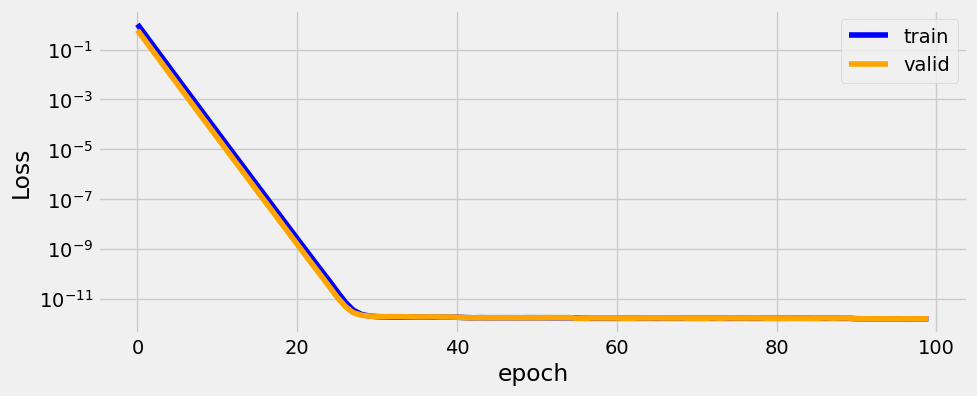

In [24]:
loss_fig = dl_assistent.show_losses();

In [25]:
dl_assistent.model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2000,  0.1000,  0.4000, -0.7000,  0.0300]], device='cuda:0')),
             ('0.bias', tensor([-0.9000], device='cuda:0'))])

In [54]:
dl_assistent.save_results('checkpoint.pth')

In [55]:
dl_assistent.load_states('checkpoint.pth')

In [25]:
X_test = np.random.randn(5, 5)
dl_assistent.attach_hook(['0'])
model_pred = dl_assistent.predict(X_test)
dl_assistent.remove_hook()
model_pred

array([[-1.6285517 ],
       [-0.1370228 ],
       [ 0.34507674],
       [-0.3947935 ],
       [ 0.37855583]], dtype=float32)

In [20]:
dl_assistent.layer_output_dict

{'0': array([[-1.6285517 ],
        [-0.1370228 ],
        [ 0.34507674],
        [-0.3947935 ],
        [ 0.37855583]], dtype=float32)}

In [26]:
y_test = np.random.randn(5, 1)
dl_assistent.show_metric(X_test, y_test, metric=mean_squared_error)

0.909290407253015

In [26]:
dl_assistent.count_parameters()

6

# Classification problem

In [22]:
%%writefile data_config/data_prep_v3.py

TRAIN_PATH = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\PytorchDLAssistant/\data/\train")
VALID_PATH = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\PytorchDLAssistant/\data/\valid")

# if not os.path.exists(VALID_PATH):
#     os.mkdir(VALID_PATH)

# cat_list = os.listdir(TRAIN_PATH)

# for cat in tqdm(cat_list):

#     if not os.path.exists(os.path.join(VALID_PATH, cat)):
#         os.mkdir(os.path.join(VALID_PATH, cat))

#     files_list = os.listdir(os.path.join(TRAIN_PATH, cat))

#     total_files = len(files_list)
#     valid_files = int(total_files*0.2)
#     valid_idxs_list = list(np.random.choice(np.arange(total_files), valid_files, replace=False))

#     for i in valid_idxs_list:
#         shutil.move(
#             os.path.join(TRAIN_PATH, cat, files_list[i]),
#             os.path.join(VALID_PATH, cat, files_list[i])
#         )

temp_data_transform = Compose([Resize((28, 28)), ToTensor()])
temp_dataset = ImageFolder(root=TRAIN_PATH, transform=temp_data_transform)
temp_loader = DataLoader(dataset=temp_dataset, batch_size=16)

normalizer = DLAssistant.create_normalizer(temp_loader)

data_transform = Compose([Resize((28, 28)), ToTensor(), normalizer])

train_dataset = ImageFolder(root=TRAIN_PATH, transform=data_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

valid_dataset = ImageFolder(root=VALID_PATH, transform=data_transform)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=16)

Writing data_config/data_prep_v3.py


In [6]:
%%writefile model_config/model_setting_v2.py

lr = 0.01

model = nn.Sequential()
model.add_module('cnn1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1)) # 16@26X26
model.add_module('activation1', nn.ReLU())
model.add_module('pool1', nn.AvgPool2d(kernel_size=2)) # 16@13X13
model.add_module('cnn2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)) # 32@11X11
model.add_module('activation2', nn.ReLU())
model.add_module('pool2', nn.AvgPool2d(kernel_size=2)) # 32@5X5
# model.add_module('cnn3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)) # 64@3X3
# model.add_module('activation3', nn.ReLU())
# model.add_module('pool3', nn.AvgPool2d(kernel_size=2)) # 64@1X1
model.add_module('flatten', nn.Flatten())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('fc', nn.Linear(32*5*5, 42))

loss_fn = nn.CrossEntropyLoss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=lr)

Writing model_config/model_setting_v2.py


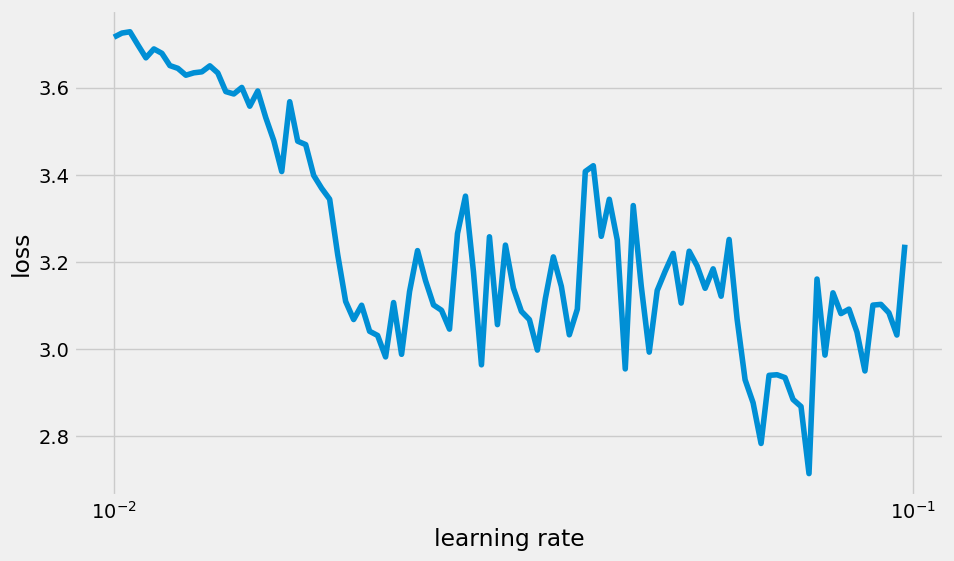

In [37]:
%run -i assistent/model.py
%run -i data_config/data_prep_v3.py
%run -i model_config/model_setting_v2.py

simple_clf_model = DLAssistant(model, loss_fn, optimizer)
simple_clf_model.lr_range_test(data_loader=train_loader, end_lr=0.03, n_iter=100, lr_mode='exp', ewma_param=0.5);

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.28E-02


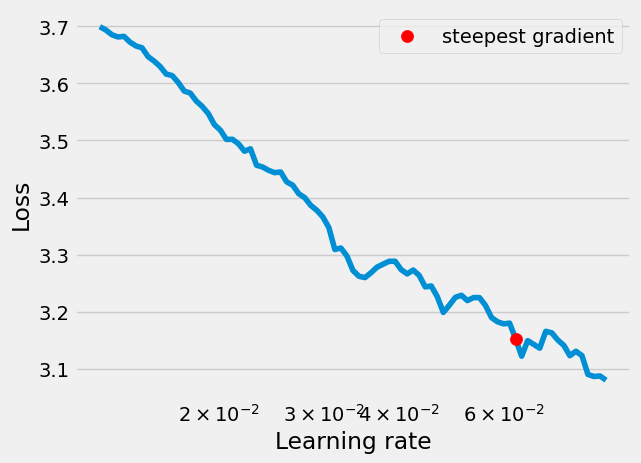

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr_finder = LRFinder(model, optimizer, loss_fn, device=device)
lr_finder.range_test(train_loader=train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(log_lr=True)
lr_finder.reset()

In [44]:
%run -i assistent/model.py
%run -i data_config/data_prep_v3.py
%run -i model_config/model_setting_v2.py

simple_clf_model = DLAssistant(model, loss_fn, optimizer)
new_optimizer = optim.SGD(model.parameters(), lr=6.28E-02)
simple_clf_model.set_optimizer(new_optimizer)
simple_clf_model.set_loaders(train_loader, valid_loader)
simple_clf_model.set_tensorboard('simple_clf')
simple_clf_model.train(n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

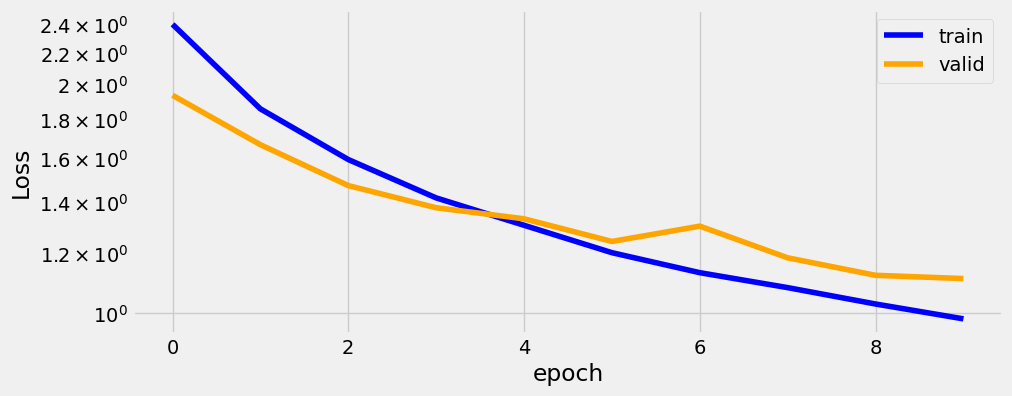

In [45]:
simple_clf_model.show_losses();

In [56]:
%run -i assistent/model.py
%run -i data_config/data_prep_v3.py
%run -i model_config/model_setting_v2.py

scheduler1 = StepLR(optimizer, step_size=4, gamma=0.5)

n_cycle_epochs = 5
step_size_up = int(len(train_loader) * n_cycle_epochs / 2)
scheduler2 = CyclicLR(optimizer, base_lr=1e-4, max_lr=6.28E-02, step_size_up=step_size_up, mode='triangular')
scheduler3 = CyclicLR(optimizer, base_lr=1e-4, max_lr=6.28E-02, step_size_up=step_size_up, mode='triangular2')
scheduler4 = CyclicLR(optimizer, base_lr=1e-4, max_lr=6.28E-02, step_size_up=step_size_up, mode='exp_range', gamma=np.sqrt(.5))

simple_clf_model = DLAssistant(model, loss_fn, optimizer)
new_optimizer = optim.SGD(model.parameters(), lr=6.28E-02)
simple_clf_model.set_optimizer(new_optimizer)
simple_clf_model.set_lr_scheduler(scheduler4)
simple_clf_model.set_loaders(train_loader, valid_loader)
simple_clf_model.set_tensorboard('simple_clf')
simple_clf_model.train(n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

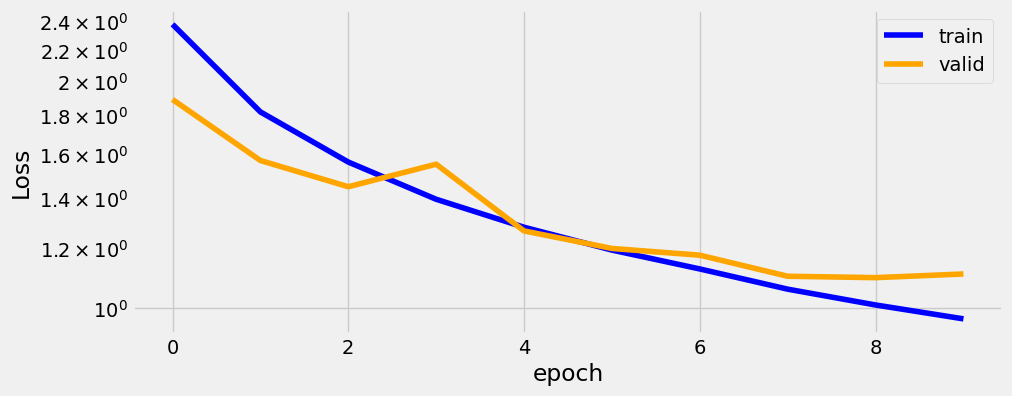

In [57]:
simple_clf_model.show_losses();

In [ ]:
optimizer = optim.SGD(
  model.parameters(), lr=0.1, momentum=0.9, nesterov=False
)

normalizer = Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225]
)

StepByStep.loader_apply(val_loader, sbs_alex.correct)

In [61]:
X_valid, y_valid = next(iter(valid_loader))
simple_clf_model.show_metric(X_valid, y_valid, metric=accuracy_score, is_classification=True)

In [72]:
%%writefile data_config/data_prep_v4.py

resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)

def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

freeze_model(resnet18_model)

resnet18_model.fc = nn.Identity()

# resnet18_model.fc = nn.Linear(2048, 42)
# resnet18_model

def extract_model_features(model, data_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    
    labels = None
    features = None

    for i, (X, y) in enumerate(data_loader):
        model.eval()
        output = model(X.to(device))
        if i == 0:
            labels = y.cpu()
            features = output.detach().cpu()
        else:
            labels = torch.cat([labels, y.cpu()])
            features = torch.cat([features, output.detach().cpu()])

    dataset = TensorDataset(features, labels)

    return dataset

TRAIN_PATH = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\PytorchDLAssistant/\data/\train")
VALID_PATH = Path(r"C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\PytorchDLAssistant/\data/\valid")

normalizer = Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225]
)

data_transform = Compose([Resize((28, 28)), ToTensor(), normalizer])

train_dataset = ImageFolder(root=TRAIN_PATH, transform=data_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

valid_dataset = ImageFolder(root=VALID_PATH, transform=data_transform)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=16)

train_feat_dataset = extract_model_features(resnet18_model, train_loader)
train_loader = DataLoader(dataset=train_feat_dataset, batch_size=16, shuffle=True)

valid_feat_dataset = extract_model_features(resnet18_model, valid_loader)
valid_loader = DataLoader(dataset=valid_feat_dataset, batch_size=16)

Overwriting data_config/data_prep_v4.py


In [74]:
%run -i data_config/data_prep_v4.py
%run -i assistent/model.py

model = nn.Sequential(nn.Linear(512, 42))
optimizer = optim.SGD(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

simple_clf_model = DLAssistant(model, loss_fn, optimizer)
simple_clf_model.set_loaders(train_loader, valid_loader)
simple_clf_model.set_tensorboard('simple_clf')
simple_clf_model.train(n_epochs=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [76]:
X_valid, y_valid = next(iter(valid_loader))
simple_clf_model.show_metric(X_valid, y_valid, metric=accuracy_score, is_classification=True)

0.125

In [75]:
def inception_loss(outputs, labels):

    try:
        main, aux = outputs
    except ValueError:
        main = outputs
        aux = None
        aux_loss = 0

    multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
    main_loss = multi_loss_fn(main, labels)
    
    if aux is not None:
        aux_loss = multi_loss_fn(aux, labels)

    total_loss = main_loss + 0.4 * aux_loss

    return total_loss

# Sequences

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('data/BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-03-01,23150.929688,23880.632813,23088.626953,23646.550781,23646.550781,24662841200
1,2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,23475.466797,20386398516
2,2023-03-03,23476.632813,23479.347656,22213.238281,22362.679688,22362.679688,26062404610
3,2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,22353.349609,11166012913
4,2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,22435.513672,13317001733


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,51733.238281,15413239245
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,54522.402344,34074411896
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,57085.371094,49756832031
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,62504.789063,83239156760
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,61198.382813,65496611844


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       366 non-null    object 
 1   Open       366 non-null    float64
 2   High       366 non-null    float64
 3   Low        366 non-null    float64
 4   Close      366 non-null    float64
 5   Adj Close  366 non-null    float64
 6   Volume     366 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 20.1+ KB


In [7]:
from sklearn.preprocessing import MinMaxScaler

N_PERIODS = 5
TRAIN_LAST_IDX = 299

mm_scaler = MinMaxScaler()

train_df = df[['Adj Close', 'Volume']].iloc[:TRAIN_LAST_IDX+1].copy()
valid_df = df[['Adj Close', 'Volume']].iloc[TRAIN_LAST_IDX+1:].copy()

train_values = mm_scaler.fit_transform(train_df)
train_df = pd.DataFrame(train_values)
train_df.columns = ['Adj Close', 'Volume']

valid_values = mm_scaler.transform(valid_df)
valid_df = pd.DataFrame(valid_values)
valid_df.columns = ['Adj Close', 'Volume']

btc_df = pd.concat([train_df, valid_df], axis=0).reset_index(drop=True)

pv_seq_list = [
    [
        [btc_df['Adj Close'].values[j], btc_df['Volume'].values[j]] 
        for j in range(i, i+N_PERIODS)
    ] 
    for i in range(btc_df.shape[0]) if i+N_PERIODS <= btc_df.shape[0]
]

target_list = [
    df['Adj Close'].values[i+N_PERIODS] - df['Adj Close'].values[i+N_PERIODS-1] 
    for i in range(df.shape[0]) 
    if i+N_PERIODS <= df.shape[0]-1
]
# target_list = list(map(lambda x: 1 if x > 0 else 0 if x == 0 else -1, target_list))
target_list = list(map(lambda x: 1 if x > 0 else 0, target_list))

print(f"Sequence length: {len(pv_seq_list)}")
print(f"Target length: {len(target_list)}")

train_seq_list = pv_seq_list[:TRAIN_LAST_IDX+1]
valid_seq_list = pv_seq_list[TRAIN_LAST_IDX+1:-1]
test_seq_list = [pv_seq_list[-1]]

train_target_list = target_list[:TRAIN_LAST_IDX+1]
valid_target_list = target_list[TRAIN_LAST_IDX+1:]

print("##### Sequence size #####")
print(f"Train: {len(train_seq_list)}, Valid: {len(valid_seq_list)}, Test: {len(test_seq_list)}")
print("##### Target size #####")
print(f"Train: {len(train_target_list)}, Valid: {len(valid_target_list)}, Test: {0}")

price_list = [
    btc_df['Adj Close'].values[i+N_PERIODS] 
    for i in range(df.shape[0]) 
    if i+N_PERIODS <= df.shape[0]-1
]

train_price_list = price_list[:TRAIN_LAST_IDX+1]
valid_price_list = price_list[TRAIN_LAST_IDX+1:]

print("##### Price size #####")
print(f"Train: {len(train_price_list)}, Valid: {len(valid_price_list)}, Test: {0}")

Sequence length: 362
Target length: 361
##### Sequence size #####
Train: 300, Valid: 61, Test: 1
##### Target size #####
Train: 300, Valid: 61, Test: 0
##### Price size #####
Train: 300, Valid: 61, Test: 0


In [8]:
X_train_tensor = torch.as_tensor(train_seq_list).float()
X_valid_tensor = torch.as_tensor(valid_seq_list).float()
X_test_tensor = torch.as_tensor(test_seq_list).float()

y_train_tensor = torch.as_tensor(train_target_list).float().view(-1, 1)
y_valid_tensor = torch.as_tensor(valid_target_list).float().view(-1, 1)

print("##### Sequence tensor size #####")
print(f"Train: {X_train_tensor.size()}, Valid: {X_valid_tensor.size()}, Test: {X_test_tensor.size()}")
print("##### Target tensor size #####")
print(f"Train: {y_train_tensor.size()}, Valid: {y_valid_tensor.size()}, Test: {0}")

price_train_tensor = torch.as_tensor(train_price_list).float().view(-1, 1)
price_valid_tensor = torch.as_tensor(valid_price_list).float().view(-1, 1)

print("##### price tensor size #####")
print(f"Train: {price_train_tensor.size()}, Valid: {price_valid_tensor.size()}, Test: {0}")

##### Sequence tensor size #####
Train: torch.Size([300, 5, 2]), Valid: torch.Size([61, 5, 2]), Test: torch.Size([1, 5, 2])
##### Target tensor size #####
Train: torch.Size([300, 1]), Valid: torch.Size([61, 1]), Test: 0
##### price tensor size #####
Train: torch.Size([300, 1]), Valid: torch.Size([61, 1]), Test: 0


In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=16
)

In [10]:
n_features = 2
hidden_dim = 2

torch.manual_seed(43)

rnn = nn.RNN(
    input_size=n_features,
    hidden_size=hidden_dim,
    batch_first=True,
    # num_layers=2,
    # bidirectional=True,
    # dropout=0.3
)

rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[-0.0651, -0.4292],
                      [ 0.5954, -0.2175]])),
             ('weight_hh_l0',
              tensor([[-0.4977, -0.5857],
                      [ 0.1286, -0.6139]])),
             ('bias_ih_l0', tensor([0.3502, 0.1772])),
             ('bias_hh_l0', tensor([ 0.6211, -0.5179]))])

In [11]:
exp_data = next(iter(train_loader))
print(exp_data[0].size, exp_data[1].size())

output, last_hidden = rnn(exp_data[0][:1])
print(output)
print(output.size())
print('###########')
print(last_hidden)
print(last_hidden.size())

<built-in method size of Tensor object at 0x000001F130F290D0> torch.Size([16, 1])
tensor([[[ 0.6604, -0.3276],
         [ 0.6008, -0.0394],
         [ 0.4691, -0.2698],
         [ 0.6854, -0.0865],
         [ 0.5407, -0.1770]]], grad_fn=<TransposeBackward1>)
torch.Size([1, 5, 2])
###########
tensor([[[ 0.5407, -0.1770]]], grad_fn=<StackBackward0>)
torch.Size([1, 1, 2])


In [70]:
class RNNModel(nn.Module):
    def __init__(self, n_feats, n_states, n_outputs):
        super(RNNModel, self).__init__()
        self.n_feats = n_feats
        self.n_states = n_states
        self.n_outputs = n_outputs
        self.hidden = None

        self.rnn = nn.RNN(
            input_size=self.n_feats,
            hidden_size=self.n_states,
            batch_first=True,
            # bidirectional=True,
            # n_layers=2,
            # dropout=0.3
        )

        self.linear = nn.Linear(self.n_states, self.n_outputs)

    def forward(self, X):
        outputs, self.hidden = self.rnn(X)
        logits = self.linear(outputs[:, -1])
        return logits.view(-1, self.n_outputs)

  0%|          | 0/100 [00:00<?, ?it/s]

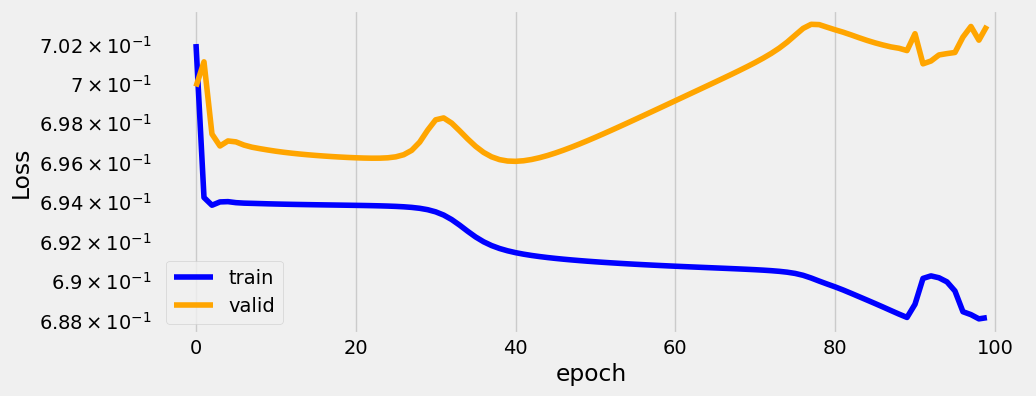

array([[0.68940324]], dtype=float32)

In [82]:
%run -i assistent/model.py

torch.manual_seed(21)
model = RNNModel(n_feats=2, n_states=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

sbs_rnn = DLAssistant(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, valid_loader)
sbs_rnn.train(100)

fig = sbs_rnn.show_losses()

sbs_rnn.predict(X_test_tensor)

In [83]:
class GRUModel(nn.Module):
    def __init__(self, n_feats, n_states, n_outputs):
        super(GRUModel, self).__init__()
        self.n_feats = n_feats
        self.n_states = n_states
        self.n_outputs = n_outputs
        self.hidden = None

        self.rnn = nn.GRU(
            input_size=self.n_feats,
            hidden_size=self.n_states,
            batch_first=True,
            # bidirectional=True,
            # n_layers=2,
            # dropout=0.3
        )

        self.linear = nn.Linear(self.n_states, self.n_outputs)

    def forward(self, X):
        outputs, self.hidden = self.rnn(X)
        logits = self.linear(outputs[:, -1])
        return logits.view(-1, self.n_outputs)

  0%|          | 0/100 [00:00<?, ?it/s]

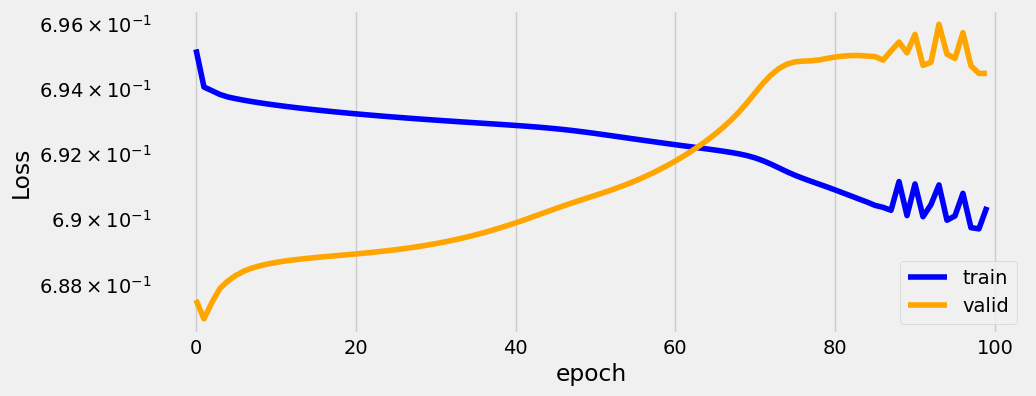

array([[0.44025248]], dtype=float32)

In [84]:
%run -i assistent/model.py

torch.manual_seed(21)
model = GRUModel(n_feats=2, n_states=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

sbs_rnn = DLAssistant(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, valid_loader)
sbs_rnn.train(100)

fig = sbs_rnn.show_losses()

sbs_rnn.predict(X_test_tensor)

In [86]:
class LSTMModel(nn.Module):
    def __init__(self, n_feats, n_states, n_outputs):
        super(LSTMModel, self).__init__()
        self.n_feats = n_feats
        self.n_states = n_states
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None

        self.rnn = nn.LSTM(
            input_size=self.n_feats,
            hidden_size=self.n_states,
            batch_first=True,
            # bidirectional=True,
            # n_layers=2,
            # dropout=0.3
        )

        self.linear = nn.Linear(self.n_states, self.n_outputs)

    def forward(self, X):
        outputs, (self.hidden, self.cell) = self.rnn(X)
        logits = self.linear(outputs[:, -1])
        return logits.view(-1, self.n_outputs)

  0%|          | 0/100 [00:00<?, ?it/s]

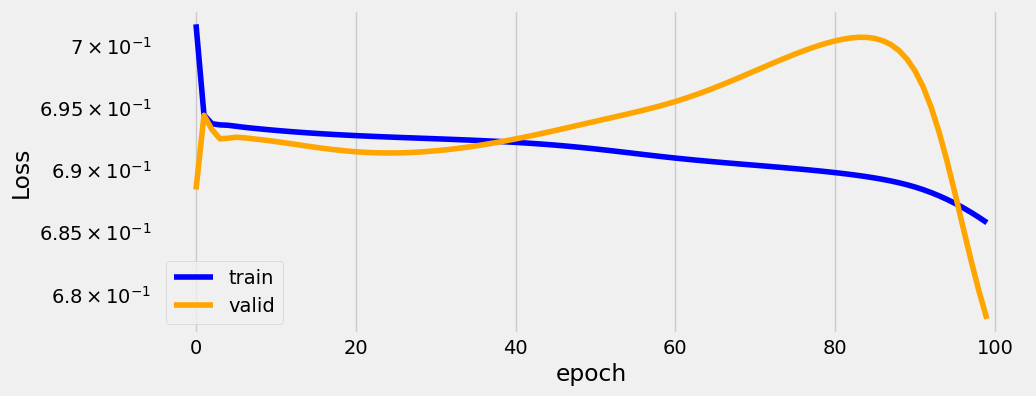

array([[0.7610841]], dtype=float32)

In [87]:
%run -i assistent/model.py

torch.manual_seed(21)
model = LSTMModel(n_feats=2, n_states=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

sbs_rnn = DLAssistant(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, valid_loader)
sbs_rnn.train(100)

fig = sbs_rnn.show_losses()

sbs_rnn.predict(X_test_tensor)

## Padding

In [89]:
s1 = exp_data[0][0]
s2 = exp_data[0][1][:3]
s3 = exp_data[0][2][:4]

all_seq = [s1, s2, s3]
all_seq_tensor = [torch.as_tensor(s).float() for s in all_seq]
padded_seq = rnn_utils.pad_sequence(all_seq_tensor, batch_first=True)
padded_seq

tensor([[[0.1443, 0.3922],
         [0.1371, 0.3054],
         [0.0907, 0.4206],
         [0.0903, 0.1184],
         [0.0938, 0.1620]],

        [[0.1371, 0.3054],
         [0.0907, 0.4206],
         [0.0903, 0.1184],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0907, 0.4206],
         [0.0903, 0.1184],
         [0.0938, 0.1620],
         [0.0935, 0.2439],
         [0.0000, 0.0000]]])

## Packing

In [90]:
packed_seq = rnn_utils.pack_sequence(all_seq_tensor, enforce_sorted=False)
packed_seq

PackedSequence(data=tensor([[0.1443, 0.3922],
        [0.0907, 0.4206],
        [0.1371, 0.3054],
        [0.1371, 0.3054],
        [0.0903, 0.1184],
        [0.0907, 0.4206],
        [0.0907, 0.4206],
        [0.0938, 0.1620],
        [0.0903, 0.1184],
        [0.0903, 0.1184],
        [0.0935, 0.2439],
        [0.0938, 0.1620]]), batch_sizes=tensor([3, 3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [94]:
packed_output, packed_hidden = rnn(packed_seq)
print(packed_output)
print(packed_hidden)

PackedSequence(data=tensor([[ 0.6604, -0.3276],
        [ 0.6555, -0.3611],
        [ 0.6811, -0.3144],
        [ 0.6008, -0.0394],
        [ 0.6640, -0.0067],
        [ 0.5581, -0.0972],
        [ 0.4691, -0.2698],
        [ 0.5147, -0.2266],
        [ 0.6004, -0.1792],
        [ 0.6854, -0.0865],
        [ 0.6274, -0.1320],
        [ 0.5407, -0.1770]], grad_fn=<CatBackward0>), batch_sizes=tensor([3, 3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))
tensor([[[ 0.5407, -0.1770],
         [ 0.6004, -0.1792],
         [ 0.6274, -0.1320]]], grad_fn=<IndexSelectBackward0>)


In [95]:
unpacked_output, seq_sizes = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
print(unpacked_output, seq_sizes)

tensor([[[ 0.6604, -0.3276],
         [ 0.6008, -0.0394],
         [ 0.4691, -0.2698],
         [ 0.6854, -0.0865],
         [ 0.5407, -0.1770]],

        [[ 0.6811, -0.3144],
         [ 0.5581, -0.0972],
         [ 0.6004, -0.1792],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[ 0.6555, -0.3611],
         [ 0.6640, -0.0067],
         [ 0.5147, -0.2266],
         [ 0.6274, -0.1320],
         [ 0.0000,  0.0000]]], grad_fn=<IndexSelectBackward0>) tensor([5, 3, 4])


In [101]:
seq_idxs = torch.arange(seq_sizes.size(0))
unpacked_output[seq_idxs, seq_sizes-1]

tensor([[ 0.5407, -0.1770],
        [ 0.6004, -0.1792],
        [ 0.6274, -0.1320]], grad_fn=<IndexBackward0>)

In [103]:
seq_len = [len(s) for s in all_seq]

padded_packed_seq = rnn_utils.pack_padded_sequence(
    padded_seq,
    seq_len,
    enforce_sorted=False,
    batch_first=True
)

padded_packed_seq

PackedSequence(data=tensor([[0.1443, 0.3922],
        [0.0907, 0.4206],
        [0.1371, 0.3054],
        [0.1371, 0.3054],
        [0.0903, 0.1184],
        [0.0907, 0.4206],
        [0.0907, 0.4206],
        [0.0938, 0.1620],
        [0.0903, 0.1184],
        [0.0903, 0.1184],
        [0.0935, 0.2439],
        [0.0938, 0.1620]]), batch_sizes=tensor([3, 3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [ ]:
def pack_collate(batch):
    X = [i[0] for i in batch]
    y = [i[1] for i in batch]
    X_packed = rnn_utils.pack_sequence(X, enforce_sorted=False)
    return X_packed, torch.as_tensor(y).view(-1, 1)

In [104]:
class RNNModel_packed(nn.Module):
    def __init__(self, n_feats, n_states, n_outputs):
        super(RNNModel_packed, self).__init__()
        self.n_feats = n_feats
        self.n_states = n_states
        self.n_outputs = n_outputs
        self.hidden = None

        self.rnn = nn.RNN(
            input_size=self.n_feats,
            hidden_size=self.n_states,
            batch_first=True,
            # bidirectional=True,
            # n_layers=2,
            # dropout=0.3
        )

        self.linear = nn.Linear(self.n_states, self.n_outputs)

    def forward(self, X):
        packed_outputs, self.hidden = self.rnn(X)
        unpacked_outputs, seq_sizes = rnn_utils.pad_packed_sequence(packed_outputs, batch_first=True)
        seq_idx = torch.arange(seq_sizes(0))
        outputs = unpacked_outputs[seq_idx, seq_sizes-1]
        logits = self.linear(outputs)
        return logits.view(-1, self.n_outputs)

In [106]:
# torch.manual_seed(21)
# model = nn.Sequential()
# model.add_module(
#     'conv1d', 
#     nn.Conv1d(
#         in_channels=2,
#         out_channels=1,
#         kernel_size=2
#     )
# )
# model.add_module('relu', nn.ReLU())
# model.add_module('flatten', nn.Flatten())
# model.add_module('output', nn.Linear(3, 1))

# loss = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)

# %run -i assistent/model.py

# sbs_rnn = DLAssistant(model, loss, optimizer)
# sbs_rnn.set_loaders(train_loader, valid_loader)
# sbs_rnn.train(100)

# fig = sbs_rnn.show_losses()

# sbs_rnn.predict(X_test_tensor)

# Encoder-Decoder

In [23]:
class Encoder(nn.Module):
    def __init__(self, n_feats, n_states):
        super().__init__()
        self.n_feats = n_feats
        self.n_states = n_states
        self.hidden = None

        self.rnn = nn.GRU(
            input_size=self.n_feats,
            hidden_size=self.n_states,
            batch_first=True
        )

    def forward(self, X):
        output, self.hidden = self.rnn(X)
        return output

In [113]:
class Decoder(nn.Module):
    def __init__(self, n_feats, n_states):
        super().__init__()
        self.n_feats = n_feats
        self.n_states = n_states
        self.hidden = None

        self.rnn = nn.GRU(
            input_size=self.n_feats,
            hidden_size=self.n_states,
            batch_first=True
        )

        self.linear = nn.Linear(self.n_states, self.n_feats)

    def init_hidden(self, hidden_seq):
        last_hidden = hidden_seq[:, -1:]
        self.hidden = last_hidden.permute(1, 0, 2)

    def forward(self, X):
        output, self.hidden = self.rnn(X, self.hidden)
        final_output = self.linear(output[:, -1:]).view(-1, 1, self.n_feats)
        return final_output

In [133]:
torch.manual_seed(42)

target_seq = exp_data[0][-1:]

encoder = Encoder(n_feats=2, n_states=2)
hidden_seq = encoder(exp_data[0][0].view(-1, 5, 2))

decoder = Decoder(n_feats=2, n_states=2)
decoder.init_hidden(hidden_seq)

decoder_input = exp_data[0][-1].view(-1, 5, 2)

teacher_forcing_prob = 0.5

target_len = 2
for i in range(target_len):
    decoder_out = decoder(decoder_input)
    if torch.randn(1) <= teacher_forcing_prob:
        decoder_input = target_seq[:, i:i+1]
    else:
        decoder_input = decoder_out

In [135]:
decoder_out

tensor([[[-0.1368, -0.2058]]], grad_fn=<ViewBackward0>)

In [9]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.teacher_forcing_prob = teacher_forcing_prob
        self.outputs = None

    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        self.outputs = torch.zeros(batch_size, self.target_len, self.encoder.n_feats).to(device)

    def save_outputs(self, idx, output):
        self.outputs[:, idx:idx+1, :] = output

    def forward(self, X):

        source_seq = X[:, :self.input_len, :]

        if self.training:
            target_seq = X[:, self.input_len:, :]
        else:
            target_seq = torch.zeros(X.shape[0], 1, self.encoder.n_feats).to(X.device)

        self.init_outputs(X.shape[0])

        hidden_seq = self.encoder(source_seq)
        
        self.decoder.init_hidden(hidden_seq)

        dec_input = source_seq[:, -1:, :]

        for i in range(self.target_len):

            dec_out = self.decoder(dec_input)

            self.save_outputs(i, dec_out)

            prob = self.teacher_forcing_prob

            if not self.training:
                prob = 0

            if torch.randn(1) < prob:
                dec_input = target_seq[:, i:i+1, :]
            else:
                dec_input = dec_out

        return self.outputs

In [12]:
target_train = X_train_tensor[:, 3:]

source_valid = X_valid_tensor[:, :3]
target_valid = X_valid_tensor[:, 3:]

train_data = TensorDataset(X_train_tensor, target_train)
valid_data = TensorDataset(source_valid, target_valid)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, generator=generator)
valid_loader = DataLoader(valid_data, batch_size=16)

  0%|          | 0/100 [00:00<?, ?it/s]

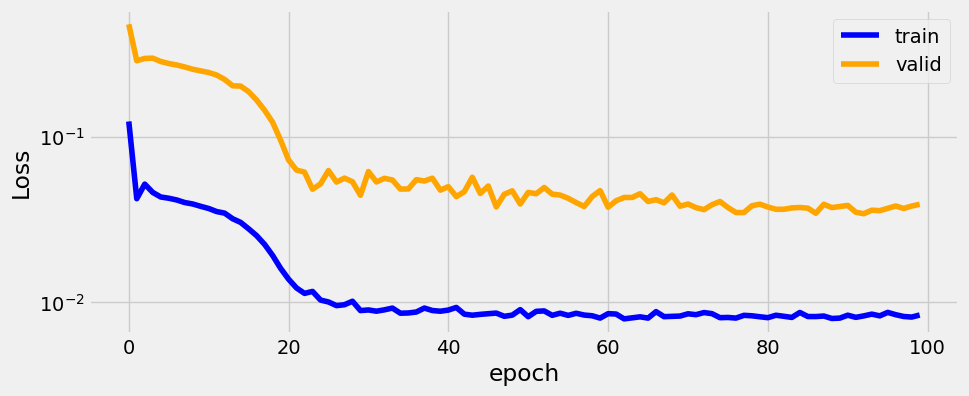

array([[[1.2006865 , 0.4897836 ],
        [1.1807477 , 0.47129613]]], dtype=float32)

In [177]:
torch.manual_seed(23)
encoder = Encoder(n_feats=2, n_states=2)
decoder = Decoder(n_feats=2, n_states=2)
model = EncoderDecoder(
    encoder, decoder,
    input_len=3, target_len=2,
    teacher_forcing_prob=0.5
)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

%run -i assistent/model.py

sbs_rnn = DLAssistant(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, valid_loader)
sbs_rnn.train(100)

fig = sbs_rnn.show_losses()

sbs_rnn.predict(X_test_tensor[:, :3])

In [179]:
X_test_tensor[:, 3:]

tensor([[[1.7647, 1.5806],
         [1.7103, 1.2206]]])

In [160]:
temp_iter = next(iter(valid_loader))
temp_iter[0].shape, temp_iter[1].shape

(torch.Size([16, 3, 2]), torch.Size([16, 2, 2]))

# Attention

In [25]:
class Attention(nn.Module):

    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        # self.hidden_dim = hidden_dim
        self.d_k = hidden_dim
        self.input_dim = input_dim if input_dim is not None else hidden_dim
        self.proj_values = proj_values
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None

    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.keys if not self.proj_values else self.linear_value(self.keys)

    def get_scores(self, query):
        self.proj_query = self.linear_query(query)
        dot_product = torch.bmm(self.proj_query, self.proj_keys.permute(0, 2, 1))
        scores = dot_product / np.sqrt(self.d_k)
        return scores
    
    def forward(self, query, mask=None):
        scores = self.get_scores(query)
        if mask is not None:
            scores = scores.masked_fill(mask==0, 1e-9)
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas.detach()
        context = torch.bmm(alphas, self.values)
        return context


In [26]:
source_seq = torch.tensor([[[-1., 1.], [0., 0.]]])
source_seq.size()

torch.Size([1, 2, 2])

In [27]:
(source_seq != 0).all(axis=2).unsqueeze(1).size()

torch.Size([1, 1, 2])

In [28]:
class DecoderAttn(nn.Module):
    def __init__(self, n_feats, n_states):
        super().__init__()
        self.n_feats = n_feats
        self.n_states = n_states
        self.hidden = None

        self.rnn = nn.GRU(
            input_size=self.n_feats,
            hidden_size=self.n_states,
            batch_first=True
        )

        self.attn = Attention(self.n_states)

        self.linear = nn.Linear(2*self.n_states, self.n_feats)

    def init_hidden(self, hidden_seq):
        self.attn.init_keys(hidden_seq)
        last_hidden = hidden_seq[:, -1:]
        self.hidden = last_hidden.permute(1, 0, 2)

    def forward(self, X, mask=None):
        output, self.hidden = self.rnn(X, self.hidden)
        query = output[:, -1:]
        context = self.attn(query, mask)
        concatenated = torch.cat([context, query], axis=-1)
        final_output = self.linear(concatenated).view(-1, 1, self.n_feats)
        return final_output

In [31]:
class EncoderDecoderAttn(EncoderDecoder):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__(encoder, decoder, input_len, target_len, teacher_forcing_prob)
        self.alphas = None

    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        self.outputs = torch.zeros(batch_size, self.target_len, self.encoder.n_feats).to(device)
        self.alphas = torch.zeros(batch_size, self.target_len, self.input_len).to(device)

    def save_outputs(self, idx, output):
        self.outputs[:, idx:idx+1, :] = output
        self.alphas[:, idx:idx+1, :] = self.decoder.attn.alphas

  0%|          | 0/100 [00:00<?, ?it/s]

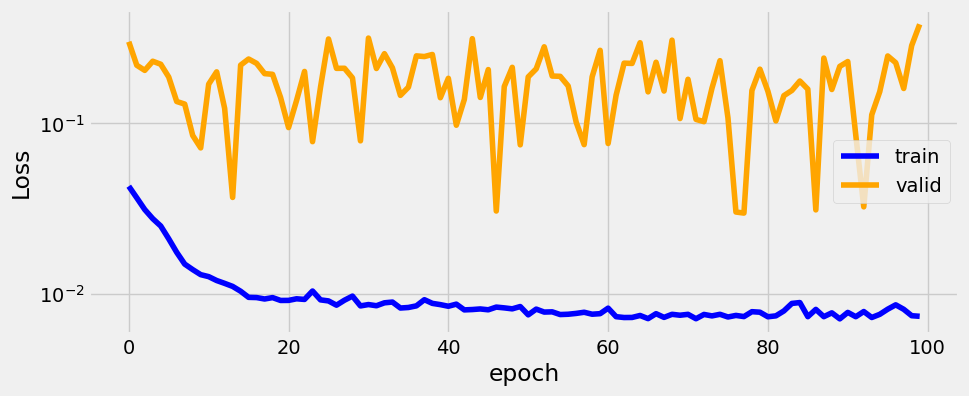

array([[[1.3073477 , 0.60068506],
        [1.2076032 , 0.53146225]]], dtype=float32)

In [32]:
torch.manual_seed(23)
encoder = Encoder(n_feats=2, n_states=2)
decoder = DecoderAttn(n_feats=2, n_states=2)
model = EncoderDecoderAttn(
    encoder, decoder,
    input_len=3, target_len=2,
    teacher_forcing_prob=0.5
)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

%run -i assistent/model.py

sbs_rnn = DLAssistant(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, valid_loader)
sbs_rnn.train(100)

fig = sbs_rnn.show_losses()

sbs_rnn.predict(X_test_tensor[:, :3])

# MultiHead Attention

In [33]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_heads, d_model, input_dim=None, proj_values=False):
        super().__init__()
        self.linear_output = nn.Linear(n_heads*d_model, d_model)
        self.attn_heads = nn.ModuleList(
            [Attention(hidden_dim=d_model, input_dim=input_dim, proj_values=proj_values) for _ in range(n_heads)]
        )

    def init_keys(self, key):
        for attn_head in self.attn_heads:
            attn_head.init_keys(key)

    @property
    def alphas(self):
        return torch.stack([attn_head.alphas for attn_head in self.attn_heads], dim=0)

    def get_multihead_context(self, contexts):
        concatenated = torch.cat(contexts, axis=-1)
        context = self.linear_output(concatenated)
        return context

    def forward(self, query, mask=None):
        contexts = [attn_head(query, mask) for attn_head in self.attn_heads]
        context = self.get_multihead_context(contexts)
        return context

In [34]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_feats=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_feats = n_feats
        self.self_attn_heads = MultiHeadAttention(n_heads=n_heads, d_model=d_model, input_dim=n_feats)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model)
        )

    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        attn = self.self_attn_heads(query, mask)
        output = self.ffn(attn)
        return output

In [35]:
class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_feats=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_feats = n_feats if n_feats is not None else d_model
        self.self_attn_heads = MultiHeadAttention(n_heads=n_heads, d_model=d_model, input_dim=self.n_feats)
        self.cross_attn_heads = MultiHeadAttention(n_heads=n_heads, d_model=d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_feats)
        )

    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        attn1 = self.self_attn_heads(query, target_mask)
        attn2 = self.cross_attn_heads(attn1, source_mask)
        output = self.ffn(attn2)
        return output

In [19]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.target_mask = self.subsequent_mask(self.target_len)

    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1)).bool()
        return subsequent_mask

    def encode(self, source_seq, source_mask):
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        output = self.decoder(shifted_target_seq, source_mask=source_mask, target_mask=target_mask)
        return output

    def predict(self, source_seq, source_mask):
        input = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(input, source_mask, self.target_mask[:, :i+1, :i+1])
            out = torch.cat([input, out[:, -1:, :]], dim=-2)
            input = out.detach()
        outputs = input[:, 1: , :]
        return outputs

    def forward(self, X, source_mask=None):
        self.target_mask = self.target_mask.type_as(X).bool()
        source_seq = X[:, :self.input_len, :]
        self.encode(source_seq, source_mask)
        if self.training:
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            outputs = self.decode(shifted_target_seq, source_mask, self.target_mask)
        else:
            outputs = self.predict(source_seq, source_mask)
        return outputs



  0%|          | 0/100 [00:00<?, ?it/s]

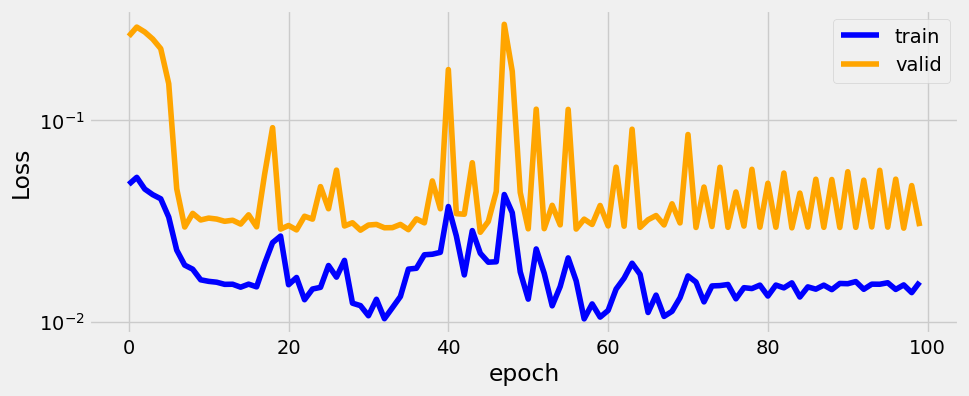

array([[[1.4362655, 0.5261415],
        [1.4362509, 0.5261372]]], dtype=float32)

In [39]:
torch.manual_seed(23)
encoder = EncoderSelfAttn(n_heads=2, d_model=2, ff_units=10, n_feats=2)
decoder = DecoderSelfAttn(n_heads=2, d_model=2, ff_units=10, n_feats=2)
model = EncoderDecoderSelfAttn(
    encoder, decoder,
    input_len=3, target_len=2
)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

%run -i assistent/model.py

sbs_rnn = DLAssistant(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, valid_loader)
sbs_rnn.train(100)

fig = sbs_rnn.show_losses()

sbs_rnn.predict(X_test_tensor[:, :3])

# Positional Encoding

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(
        torch.arange(0, d_model, 2).float() *
        (-np.log(10000.0) / d_model)
        )
        # even dimensions
        pe[:, 0::2] = torch.sin(position * angular_speed)
        # odd dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

In [23]:
class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units,
    n_feats=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_feats is None else n_feats
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model,
        ff_units, n_feats)

    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out

In [24]:
class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units,
    n_feats=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_feats is None else n_feats
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model,
        ff_units, n_feats)

    def init_keys(self, states):
        self.layer.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

  0%|          | 0/100 [00:00<?, ?it/s]

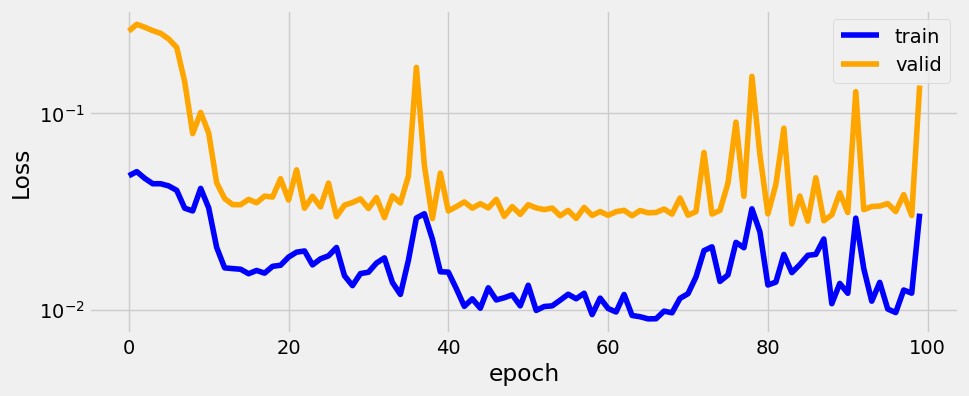

array([[[0.8471418, 0.303361 ],
        [0.8471428, 0.3033613]]], dtype=float32)

In [47]:
torch.manual_seed(23)
encoder = EncoderPe(n_heads=2, d_model=2, ff_units=10, n_feats=2)
decoder = DecoderPe(n_heads=2, d_model=2, ff_units=10, n_feats=2)
model = EncoderDecoderSelfAttn(
    encoder, decoder,
    input_len=3, target_len=2
)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

%run -i assistent/model.py

sbs_rnn = DLAssistant(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, valid_loader)
sbs_rnn.train(100)

fig = sbs_rnn.show_losses()

sbs_rnn.predict(X_test_tensor[:, :3])

# Transformers

In [27]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout_prob=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model/n_heads)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_output = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.alphas = None

    def make_chunks(self, x):
        batch_size, seq_length = x.size(0), x.size(1)
        x = x.view(batch_size, seq_length, self.n_heads, self.d_k)
        x = x.transpose(1, 2)
        return x
    
    def init_keys(self, key):
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))

    def get_score(self, query):
        self.proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(
            self.proj_query,
            self.proj_key.transpose(-2, -1)
        )
        scores = dot_products / np.sqrt(self.d_k)
        return scores
    
    def get_context(self, query, mask=None):
        scores = self.get_score(query)
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        alphas = F.softmax(scores, dim=-1)
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()
        context = torch.matmul(alphas, self.proj_value)
        return context
    
    def get_output(self, contexts):
        output = self.linear_output(contexts)
        return contexts
    
    def forward(self, query, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)

        context = self.get_context(query, mask)
        context = context.transpose(1, 2).contiguous()
        context = context.view(query.size(0), -1, self.d_model)
        output = self.get_output(context)
        return output

In [28]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, query, mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Multi-headed Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, mask)
        # Add
        att = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att = self.norm2(att)
        # Feed Forward
        out = self.ffn(norm_att)
        # Add
        out = att + self.drop2(out)
        return out

In [29]:
import copy

class EncoderTransf(nn.Module):
    def __init__(self, encoder_layer, n_layers=1, max_len=100):
        super().__init__()
        self.d_model = encoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(n_layers)])

    def forward(self, query, mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, mask)
        # Norm
        return self.norm(x)

In [30]:
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.self_attn_heads = MultiHeadedAttention(n_heads, d_model, dropout)
        self.cross_attn_heads = MultiHeadedAttention(n_heads, d_model, dropout)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, d_model),
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)

    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        # Sublayer #0
        # Norm
        norm_query = self.norm1(query)
        # Masked Multi-head Attention
        self.self_attn_heads.init_keys(norm_query)
        states = self.self_attn_heads(norm_query, target_mask)
        # Add
        att1 = query + self.drop1(states)
        
        # Sublayer #1
        # Norm
        norm_att1 = self.norm2(att1)
        # Multi-head Attention
        encoder_states = self.cross_attn_heads(norm_att1,
        source_mask)
        # Add
        att2 = att1 + self.drop2(encoder_states)
        
        # Sublayer #2
        # Norm
        norm_att2 = self.norm3(att2)
        # Feed Forward
        out = self.ffn(norm_att2)
        # Add
        out = att2 + self.drop3(out)
        return out

In [31]:
class DecoderTransf(nn.Module):
    def __init__(self, decoder_layer, n_layers=1, max_len=100):
        super(DecoderTransf, self).__init__()
        self.d_model = decoder_layer.d_model
        self.pe = PositionalEncoding(max_len, self.d_model)
        self.norm = nn.LayerNorm(self.d_model)
        self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(n_layers)])

    def init_keys(self, states):
        for layer in self.layers:
            layer.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        # Positional Encoding
        x = self.pe(query)
        for layer in self.layers:
            x = layer(x, source_mask, target_mask)
        # Norm
        return self.norm(x)


In [32]:
class EncoderDecoderTransf(EncoderDecoderSelfAttn):
    def __init__(self, encoder, decoder,
        input_len, target_len, n_features):
        super(EncoderDecoderTransf, self).__init__(
            encoder, decoder, input_len, target_len
        )
        self.n_features = n_features
        self.proj = nn.Linear(n_features, encoder.d_model)
        self.linear = nn.Linear(encoder.d_model, n_features)

    def encode(self, source_seq, source_mask=None):
        # Projection
        source_proj = self.proj(source_seq)
        encoder_states = self.encoder(source_proj, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq,
        source_mask=None, target_mask=None):
        # Projection
        target_proj = self.proj(shifted_target_seq)
        outputs = self.decoder(target_proj,
        source_mask=source_mask,
        target_mask=target_mask)
        # Linear
        outputs = self.linear(outputs)
        return outputs

  0%|          | 0/100 [00:00<?, ?it/s]

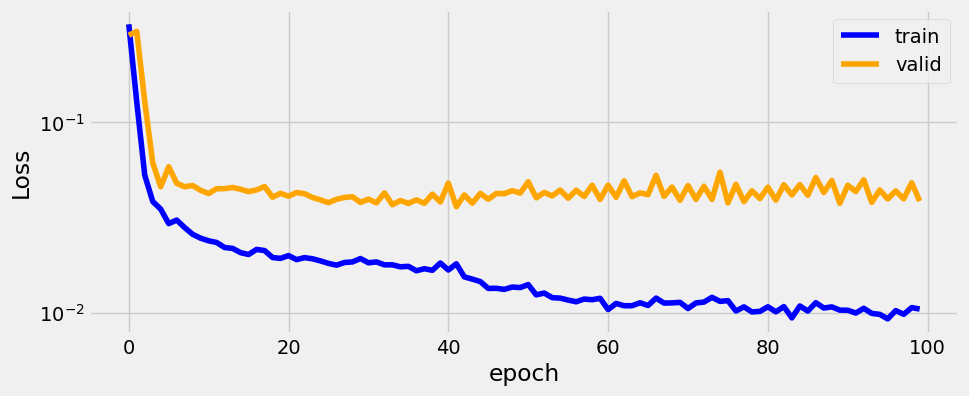

array([[[1.1790847 , 0.51933974],
        [1.133686  , 0.47090453]]], dtype=float32)

In [33]:
torch.manual_seed(42)
# Layers
enclayer = EncoderLayer(n_heads=3, d_model=6,
ff_units=10, dropout=0.1)
declayer = DecoderLayer(n_heads=3, d_model=6,
ff_units=10, dropout=0.1)
# Encoder and Decoder
enctransf = EncoderTransf(enclayer, n_layers=2)
dectransf = DecoderTransf(declayer, n_layers=2)
# Transformer
model_transf = EncoderDecoderTransf(
    enctransf, dectransf, input_len=3, target_len=2, n_features=2
)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transf.parameters(), lr=0.01)

for p in model_transf.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)


%run -i assistent/model.py

sbs_rnn = DLAssistant(model_transf, loss, optimizer)
sbs_rnn.set_loaders(train_loader, valid_loader)
sbs_rnn.train(100)

fig = sbs_rnn.show_losses()

sbs_rnn.predict(X_test_tensor[:, :3])

# Vision transformers

### Patches

In [45]:
def extract_image_patches(x, kernel_size, stride=1, n=1):
    # Extract patches
    patches = x.unfold(2, kernel_size, stride)
    patches = patches.unfold(3, kernel_size, stride)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    return patches.view(n, patches.shape[1], patches.shape[2], -1)

In [47]:
img = torch.as_tensor(np.random.randn(12, 12).reshape(1, 12, 12)).float().unsqueeze(0)
# img = img.view(1, img.size(0), img.size(1))

kernel_size = 4
patches = extract_image_patches(
  img, kernel_size, stride=kernel_size
)
patches.shape


torch.Size([1, 3, 3, 16])

In [48]:
seq_patches = patches.view(-1, patches.size(-1))
seq_patches.shape

torch.Size([9, 16])

In [49]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16,
    in_channels=3, embed_dim=768, dilation=1):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [50]:
torch.manual_seed(13)
patch_embed = PatchEmbed(
  img.size(-1), kernel_size, 1, kernel_size**2
)
embedded = patch_embed(img)
embedded.shape

torch.Size([1, 9, 16])

In [51]:
cls_token = nn.Parameter(torch.zeros(1, 1, 16))
cls_token

Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],
       requires_grad=True)

In [52]:
embed = patch_embed(img)
embed.size()

torch.Size([1, 9, 16])

In [53]:
cls_tokens = cls_token.expand(embed.size(0), -1, -1)
embed_cls = torch.cat((cls_tokens, embed), dim=1)
embed_cls.shape

torch.Size([1, 10, 16])

In [54]:
class ViT(nn.Module):
    def __init__(self, encoder, img_size, in_channels, patch_size, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(encoder.d_model, n_outputs)

        self.embed = PatchEmbed(img_size, patch_size,in_channels, encoder.d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, encoder.d_model))

    def preprocess(self, X):
        # Patch embeddings
        # N, L, F -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source):
        # Encoder generates "hidden states"
        states = self.encoder(source)
        # Gets state from first token: CLS
        cls_state = states[:, 0] # N, 1, D
        return cls_state

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src)
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

In [ ]:
torch.manual_seed(17)
layer = EncoderLayer(n_heads=2, d_model=16, ff_units=20)
encoder = EncoderTransf(layer, n_layers=1)
model_vit = ViT(encoder, img_size=12, in_channels=1, patch_size=4, n_outputs=3)
multi_loss_fn = nn.CrossEntropyLoss()
optimizer_vit = optim.Adam(model_vit.parameters(), lr=1e-3)